### Citations (APA Style):

- Jakkula, V.R. (2011). Tutorial on Support Vector Machine ( SVM ).

- Auria, Laura and Moro, R. A., Support Vector Machines (SVM) as a Technique for Solvency Analysis (August 1, 2008). DIW Berlin Discussion Paper No. 811, Available at SSRN: https://ssrn.com/abstract=1424949 or http://dx.doi.org/10.2139/ssrn.1424949

[Read more about SVMs by clicking here.](https://scikit-learn.org/stable/modules/svm.html)

Import locally required modules

In [1]:
# Add local modules' path
# Restart notebook if you modify these imports' files
import os
import sys

module_path = os.path.abspath(os.path.join("..", "common"))

if module_path not in sys.path:
    sys.path.append(module_path)

# Actual imports
from common import kUtils

Get the split data

In [2]:
import numpy as np # Used here only for the data type but extensively used later

X_train: np.ndarray; X_test: np.ndarray; X_val: np.ndarray; y_train: np.ndarray; y_test: np.ndarray; y_val: np.ndarray;

X_train, X_test, X_val, y_train, y_test, y_val = kUtils.get_split_data()


Set up the model and train it.

In [3]:
from sklearn.svm import SVC

model: SVC = SVC(kernel="linear") # Try out different kernels

classifier: SVC = model.fit(X=X_train, y=y_train)

### Metrics

In [4]:
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix

y_pred: np.ndarray = classifier.predict(X_test)

score: float = classifier.score(X=X_test, y=y_test)
accuracy: float = accuracy_score(y_true=y_test, y_pred=y_pred)
mse: float | np.ndarray = mean_squared_error(y_true=y_test, y_pred=y_pred)
c_report: str | dict = classification_report(y_true=y_test, y_pred=y_pred)
c_matrix: np.ndarray = confusion_matrix(y_true=y_test, y_pred=y_pred)

print("Score:", score)
print("Accuracy:", accuracy)
print("Mean squared error:", mse)
print("Classification report:\n", c_report)
print("Confusion matrix:\n", c_matrix)

Score: 0.9908571428571429
Accuracy: 0.9908571428571429
Mean squared error: 0.009142857142857144
Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6977
         1.0       0.99      0.99      0.99      7023

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000

Confusion matrix:
 [[6915   62]
 [  66 6957]]


### Plotting the model

The high dimensional data can be reduced to a 2D representation through applying a PCA.

In [5]:
from sklearn.decomposition import PCA

pca: PCA = PCA(n_components=2)
X_pca: np.ndarray = pca.fit_transform(X_train) # For displaying points in this new layout
support_vectors_pca: np.ndarray = pca.transform(classifier.support_vectors_) # Used to display actual support vectors

The variance of the PCA is also important to note. It thankfully captures the data well.

In [6]:
explained_variance: np.ndarray = pca.explained_variance_ratio_ * 100
print(f"PC1 explains {explained_variance[0]:.2f}% of the variance")
print(f"PC2 explains {explained_variance[1]:.2f}% of the variance")
print(f"Variance explained by all principal components: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

PC1 explains 98.60% of the variance
PC2 explains 0.31% of the variance
Variance explained by all principal components: 98.91%


Let's set up our points to plot.

In [7]:
h: float; x_min: float; x_max: float; y_min: float; y_max: float;

h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

xx: np.ndarray; yy: np.ndarray; zz: np.ndarray;

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In order for our PCA plot to correctly show our model's output we have to predict our outputs in this new space and then reshape the predicted outputs to align with the axis.

In [8]:
y_pred: np.ndarray = classifier.decision_function(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
zz_distances: np.ndarray = y_pred.reshape(xx.shape)
zz = (zz_distances > 0)

Let's set up our visual boundaries, which should make the distinction between points much clearer.

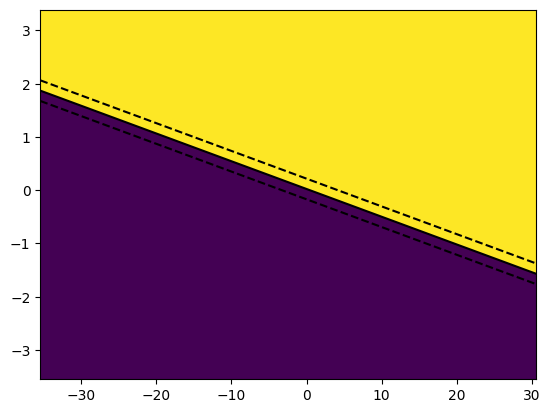

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from sklearn.inspection import DecisionBoundaryDisplay

fig: Figure; ax: plt.Axes;

fig, ax = plt.subplots()

ax.contour(xx, yy, zz_distances, levels=[0], colors="k", linestyles="-")  # Decision boundary
ax.contour(xx, yy, zz_distances, levels=[-1, 1], colors="k", linestyles="--")  # Margins

dbd: DecisionBoundaryDisplay = DecisionBoundaryDisplay(
    xx0=xx,
    xx1=yy,
    response=zz,
)

dbd.plot(plot_method="pcolormesh", ax=ax)

Time to plot it all together!

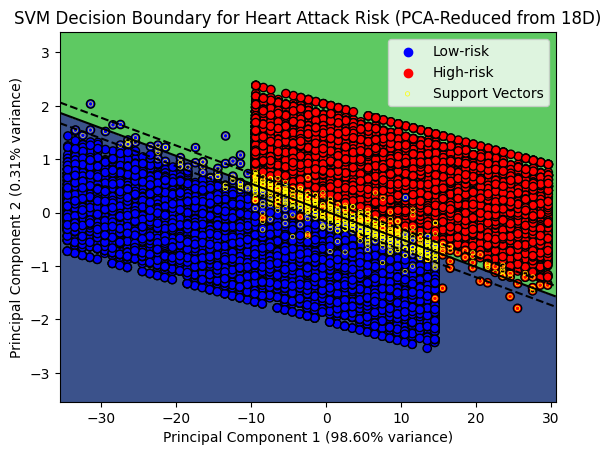

In [10]:

#  Styling
# from matplotlib import colormaps, colors
from matplotlib.colors import ListedColormap
# print(colormaps)
# print(colors.cnames)

plt.contourf(xx, yy, zz)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=ListedColormap(["blue", "red"]), edgecolors='black')
plt.scatter([], [], color="blue", label="Low-risk")
plt.scatter([], [], color="red", label="High-risk")

plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], 
            facecolors='none', edgecolors='yellow', linewidths=0.5, s=10, label="Support Vectors")

plt.contour(xx, yy, zz_distances, levels=[0], colors="black", linestyles="-")  # Decision boundary
plt.contour(xx, yy, zz_distances, levels=[-1, 1], colors="black", linestyles="--")  # Margins

plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}% variance)')
plt.title('SVM Decision Boundary for Heart Attack Risk (PCA-Reduced from 18D)')
plt.legend()
plt.show()

### Additional Metrics

The features sorted by most indicative of a heart attack.

In [11]:
import pandas as pd

feature_list: list[str] = kUtils.get_feature_list()

feature_importance: pd.DataFrame = pd.DataFrame(
    pca.components_,
    columns=[feature_list[i] for i in range(len(X_train[0,]))],
    index=['PC1', 'PC2'],
)
feature_importance = feature_importance.sort_values(by=["PC1", "PC2"], axis="columns", ascending=False)

print("Feature Contributions to Principal Components:\n", feature_importance.T)


Feature Contributions to Principal Components:
                           PC1       PC2
Age                  0.999281 -0.037877
Pain_Arms_Jaw_Back   0.011206  0.282691
Cold_Sweats_Nausea   0.011169  0.282846
Shortness_of_Breath  0.011142  0.280823
Chest_Pain           0.011046  0.280417
Swelling             0.011012  0.284714
Fatigue              0.010991  0.286267
Dizziness            0.010901  0.285884
Palpitations         0.010897  0.286280
High_Cholesterol     0.007513  0.202878
Obesity              0.007501  0.206782
Sedentary_Lifestyle  0.007483  0.203340
High_BP              0.007405  0.206334
Smoking              0.007308  0.201352
Family_History       0.007257  0.199722
Diabetes             0.007245  0.201856
Chronic_Stress       0.007085  0.207358
Gender               0.005351  0.149814
